# Demo code associated with article "Unveiling Inter-Embryo Variability in Spindle Length over time: towards Quantitative Phenotype Analysis." by Y. Le Cunff et al. 2024

Code authors: Yann Le Cunff, Jacques Pécréaux

February 2024

CNRS, Univ Rennes, IGDR (Institut de Génétique et Développement de Rennes) – UMR 6290, F-35000 Rennes, France

License: [CeCILL v2.1, see file Licence_CeCILL_V2.1-en.txt](./Licence_CeCILL_V2.1-en.txt)

## Importing libraries and subfunctions

In [31]:
import colorcet as cc # fig S3 at least
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
import numpy as np
import scipy.signal as sg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import scipy as sp
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

### Data display

In [32]:
def all_cond_detail(genef, tempef, strainf, all_expf, pidf, is_RNAif=None): 
    all_condf=genef.merge(tempef,left_index=True, right_index=True)
    all_condf=all_condf.merge(strainf,left_index=True, right_index=True)
    all_condf=all_condf.merge(all_expf,left_index=True, right_index=True)
    all_condf=all_condf.merge(pidf,left_index=True, right_index=True)
    if is_RNAif is not None:
        all_condf=all_condf.merge(is_RNAif,left_index=True, right_index=True)
    return all_condf

## Settings and Data

In [33]:
sizeK=49 #odd and 1.5s
stem='/Users/jacques/Documents/Labo_SSD/ownCloud/PCA paper/Sources_papierACP/Files_JP/Code_and_Data'

### Description of the data file.
Data are shaped as comma-separated values. The data feature several files with one experiment/cell/embryo (later named embryo) per row except for `time.csv` and `groupOfConds.csv`. 

#### Elgonation data.
The essential data are `spindlef.csv`. It contains the length of the embryo over time. One embryo per row and columns correspond to monotonically increasing times. Corresponding times are in the single-column file `time.csv` in the same order. It features a first column named *did* identifying uniquely the embryo, and then columns corresponding to time numbered with an integer from 0.

#### Description of each cell/experiment.
Some additional files are used to describe and filter the data if needed. In these files, rows are expected to be in the same order as in `spindlef.csv`, although a common identifier, named *did*, is used as an indexer. Thus, each value of *did* should be unique to an embryo. This identifier is alphanumeric. 

For each embryo, the following data are needed:
* `gene.csv` reports the condition's name (called target in Table S1, column *gene*). It features two columns named *did* and *gene*, the latter being a string value;
* `tempef.csv` reports the temperature at which the experiment was performed. It features two columns named *did* and *tempe*, the latter being a string value, usually a number and the temperature system (C for Celsius);
* `is_RNAif.csv` reports whether the depletion, if applicable, was obtained by RNAi.  It features two columns named *did* and *is_RNAi*, the latter being boolean. False is the proper value for non-treated embryos.
* `strainf.csv` reports the name of the strain used. It features two columns named *did* and *strain*, the latter being a string value;
* `all_expf.csv` reports the detail of the experiment condition that cannot fit in other fields. It features two columns named *did* and *all_exp*, the latter being a string value;
* `pidf.csv` is a unique identifier for the condition. All embryos/cells submitted to the same treatment, temperature and coming from the same strain will have the same value.  It features two columns named *did* and *pid*, the latter being a string value;

#### Clustering per group of conditions (Fig 6)
`groupOfConds.csv` To cluster the different conditions into functionally relevant groups, we used a csv file featuring three columns: *condition* that corresponds to the one in the *gene* column of the `genef.csv` file; *group* which contains a short string for the group; and *Details* that contains some facultative and textual details about the group.
 

In [34]:
time=pd.read_csv(os.path.join(stem,'time.csv'), header=0, index_col=None)
spindlef=pd.read_csv(os.path.join(stem,'spindlef.csv'), header=0, index_col='did')
genef=pd.read_csv(os.path.join(stem,'genef.csv'), header=0, index_col='did')
tempef=pd.read_csv(os.path.join(stem,'tempef.csv'), header=0, index_col='did')
all_expf=pd.read_csv(os.path.join(stem,'all_expf.csv'), header=0, index_col='did')
strainf=pd.read_csv(os.path.join(stem,'strainf.csv'), header=0, index_col='did')
pidf=pd.read_csv(os.path.join(stem,'pidf.csv'), header=0, index_col='did')
is_RNAif=pd.read_csv(os.path.join(stem,'is_RNAif.csv'), header=0, index_col='did')
groupOfConds=pd.read_csv(os.path.join(stem,'groupOfConds.csv'), header=0, index_col=0)

halfsizeK = int((sizeK+1)/2)

### additional data shaping

In [35]:
allConds=all_cond_detail(genef=genef, tempef=tempef, strainf=strainf, all_expf=all_expf, pidf=pidf).sort_values(by=['gene', 'strain'])

### averages and smoothed data

In [36]:
averageplot = pd.concat([time , pd.DataFrame(np.average(spindlef, axis = 0))], axis = 1)
averageplot.columns = ["Time", "Value"]
averageplot_trimmed = pd.DataFrame(sg.medfilt(averageplot, [sizeK,1]))
averageplot_trimmed = averageplot.iloc[halfsizeK:-halfsizeK]

In [37]:
spindle_smoothf_a =sg.medfilt(spindlef, [1, sizeK])
spindle_smoothf = pd.DataFrame(spindle_smoothf_a,index=spindlef.index)

In [38]:
data_tot_smooth = pd.concat([genef, tempef,spindle_smoothf], axis = 1) 

# Exploring the data

## All trajectories at 18C averaged per condition

### select the data

In [39]:
# Keeping only RNAi at a given temperature + wild type
tempeint = "18C"
min_tracks_to_plot=6

# Exploring the corresponding data
tk=(tempef==tempeint)
geneff = genef.loc[tk.values]
tempeff = tempef.loc[tk.values]
strainff = strainf.loc[tk.values]
all_expff = all_expf.loc[tk.values]
pidff = pidf.loc[tk.values]
print("Count of conditions")
acff=all_cond_detail(genef=geneff, tempef=tempeff, strainf=strainff, all_expf=all_expff, pidf=pidff).sort_values(by=['gene', 'strain'])

display(geneff.drop_duplicates())
ngff=geneff.drop_duplicates().shape[0]
print('Number of genes to consider in toto: ' + str(ngff))
print('\n')

#strains included
display(strainff.drop_duplicates())
ns=strainff.drop_duplicates().shape[0]
print('Number of strains considered in toto: ' + str(ns))
print('\n')
pd.set_option('display.max_rows', 10)

Count of conditions


gene
did               
ID2057    bmk1-18C
ID1968    cls2-18C
ID2429    JEP5mbk2
ID1951        mbk2
ID1803       dyrb1
...            ...
ID8968   ebp2clip1
ID9490   dyci1ebp2
ID8901        gpb1
ID10612   spd2-18C
ID9802        cid1

[88 rows x 1 columns]

Number of genes to consider in toto: 88




strain
did          
ID2057   TH27
ID2429   JEP5
ID4806   JEP6
ID2608  TH102
ID2334   JEP1
...       ...
ID3002  JEP10
ID2611  TH231
ID7079  JEP16
ID7311  JEP17
ID8968  JEP46

[17 rows x 1 columns]

Number of strains considered in toto: 17




### Plotting

=> Included gene bmk1-18C
=> Included gene cls2-18C
=> Included gene JEP5mbk2
=> Included gene mbk2
=> Included gene dyrb1
=> Included gene efa6-18C
=> Included gene egl5
=> Included gene goa1
Excluded gene mab5 because to few tracks
=> Included gene nmy2
=> Included gene none-18C
Excluded gene ubxn2 because to few tracks
=> Included gene klp3
=> Included gene klp7
Excluded gene klp10 because to few tracks
Excluded gene klp17 because to few tracks
=> Included gene klp18
=> Included gene klp19
=> Included gene klp20
=> Included gene lin5-18C
Excluded gene JEP6lin5-18C because to few tracks
=> Included gene ptl1
=> Included gene unc104
Excluded gene daf7 because to few tracks
Excluded gene TH102none because to few tracks
Excluded gene vab8 because to few tracks
=> Included gene dli1
=> Included gene JEP1klp13-18C
=> Included gene klp13-18C
=> Included gene JEP27noneebp2
=> Included gene ANA019none
=> Included gene gpa16
=> Included gene tac1
=> Included gene unc59
=> Included gene L4440e

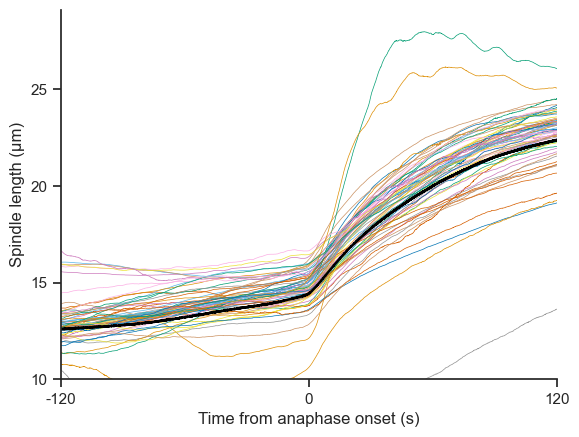

In [40]:
# Plotting
sns.set()
sns.set(font="Arial")
sns.set(font_scale=8)
sns.set(rc={"lines.linewidth": 0.5});
sns.set_palette('colorblind',ngff)

plt.figure();
with sns.axes_style("ticks"):
    ncurve = 0
    nexcl = 0
    for g in geneff["gene"].unique():
        selec = np.logical_and(genef["gene"] == g, np.asarray(tempef["tempe"] == tempeint))
        traj_of_interest = spindlef.loc[ selec]
        if traj_of_interest.shape[0] > min_tracks_to_plot:
            traj_smoothed =sg.medfilt(traj_of_interest, [1, sizeK])
            av_traj = np.average(traj_smoothed, axis = 0)
            traj_cur = pd.DataFrame(np.transpose(av_traj))
            traj_plot = pd.concat([time , traj_cur], axis = 1)
            traj_plot.columns = ["Time", "Value"]
            traj_plot = traj_plot.iloc[halfsizeK:-halfsizeK]
            graph = sns.lineplot(x = "Time", y = "Value", data = traj_plot);
            ncurve+=1
            print('=> Included gene ' + str(g))
        else:
            print('Excluded gene ' + str(g) + ' because to few tracks')
            nexcl+=1
    sns.set(rc={"lines.linewidth": 1.8});
    graph_av = sns.lineplot(x = "Time", y = "Value", data = averageplot_trimmed, color = "black") #, label = "Average spindle length of the whole dataset");
    print(str(ncurve) + " to display")
    print(str(nexcl) + " excluded")
    print("TOTAL conditions: "+str(ncurve+nexcl))

    graph_av.set(xlim=(-120, 120))
    graph_av.set(ylim=(10000, None))
    graph_av.set_xticks([-120,0,120],labels=['-120','0','120']) 
    graph_av.set_yticks([10000,15000,20000,25000],labels=['10','15','20','25']) 
    graph_av.set(xlabel="Time from anaphase onset (s)", ylabel="Spindle length (µm)")
sns.despine()

## Individual trajectories for a given condition

In [41]:
def one_cond_plotter_bis(spindlef,selec,tag=""):    
    tk=selec
    
    geneff = genef.loc[tk]
    print("Count of conditions")
    display(geneff.drop_duplicates())
    ngff=geneff.shape[0]
    print('Number of embryos to consider: ' + str(ngff))
    print('\n')
    
    sns.set();
    sns.set(rc={"lines.linewidth": 0.8});
    sns.set_palette('colorblind',ngff);
    plt.figure();
    with sns.axes_style("ticks"):
        ncurve = 0
        traj_of_interest = spindlef.loc[selec]
        traj_smoothed =sg.medfilt(traj_of_interest, [1, sizeK])
        traj_smoothed = pd.DataFrame(np.transpose(traj_smoothed))
        for i in range(0,traj_smoothed.shape[1]):
            print('Plotted at index '+str(i))
            traj_smoothed_plot = pd.concat([time , traj_smoothed.iloc[:][i]], axis = 1)
            traj_smoothed_plot.columns = ["Time", "Value"]
            traj_smoothed_plot = traj_smoothed_plot.iloc[halfsizeK:-halfsizeK]
            graph = sns.lineplot(x = "Time", y = "Value", data = traj_smoothed_plot);
            ncurve+=1
    
        av_traj = np.average(traj_smoothed, axis = 1)
        traj_cur = pd.DataFrame(np.transpose(av_traj))
        traj_plot = pd.concat([time , traj_cur], axis = 1)
        traj_plot.columns = ["Time", "Value"]
        traj_plot = traj_plot.iloc[halfsizeK:-halfsizeK]
        sns.set(rc={"lines.linewidth": 1.8});
        graph = sns.lineplot(x = "Time", y = "Value", data = traj_plot,  color = 'blue', label = 'Average spindle length over the condition');
        graph.lines[traj_smoothed.shape[1]].set_linestyle("--")
        sns.set(rc={"lines.linewidth": 1.8});
        graph_av = sns.lineplot(x = "Time", y = "Value", data = averageplot_trimmed, color = "black", label = "Average spindle length of the whole dataset");
        print(str(ncurve) + " to display")
    
        fig = plt.gcf()
        graph_av.set(xlim=(-120, 120))
        graph_av.set(ylim=(10000, None))
        graph_av.set_xticks([-120,0,120],labels=['-120','0','120']) 
        graph_av.set_yticks([10000,15000,20000,25000], labels=['10','15','20','25']) 
        graph_av.set(xlabel="Time from anaphase onset (s)", ylabel="Spindle length (µm)")
    sns.despine()
    plt.show()

def one_cond_plotter(tempeint,geneint):
    selec = np.logical_and(genef["gene"] == geneint, np.asarray(tempef["tempe"] == tempeint))
    one_cond_plotter_bis(spindlef,selec)

Count of conditions


gene
did             
ID5255  none-18C

Number of embryos to consider: 58


Plotted at index 0
Plotted at index 1
Plotted at index 2
Plotted at index 3
Plotted at index 4
Plotted at index 5
Plotted at index 6
Plotted at index 7
Plotted at index 8
Plotted at index 9
Plotted at index 10
Plotted at index 11
Plotted at index 12
Plotted at index 13
Plotted at index 14
Plotted at index 15
Plotted at index 16
Plotted at index 17
Plotted at index 18
Plotted at index 19
Plotted at index 20
Plotted at index 21
Plotted at index 22
Plotted at index 23
Plotted at index 24
Plotted at index 25
Plotted at index 26
Plotted at index 27
Plotted at index 28
Plotted at index 29
Plotted at index 30
Plotted at index 31
Plotted at index 32
Plotted at index 33
Plotted at index 34
Plotted at index 35
Plotted at index 36
Plotted at index 37
Plotted at index 38
Plotted at index 39
Plotted at index 40
Plotted at index 41
Plotted at index 42
Plotted at index 43
Plotted at index 44
Plotted at index 45
Plotted at index 46
Plotted at index 47
Plotted at ind

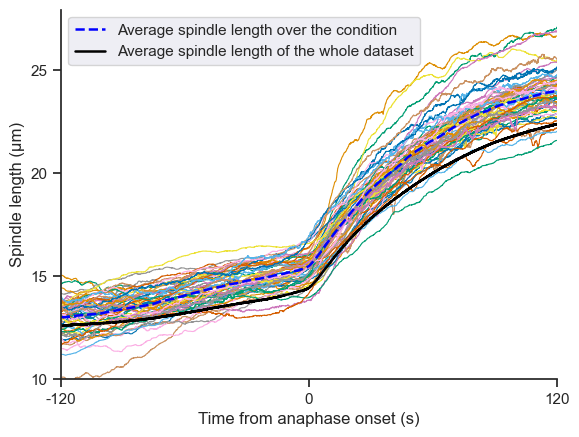

In [42]:
tempeint = "18C" # temperature of interest
geneint = "none-18C" # condition of interest
one_cond_plotter(tempeint,geneint)

# Projecting the data using PCA

### Constants for PCA

In [43]:
maxdim = 10 # Setting the PCA dimension for reconstruction
ndim_tot = 20 # max number of dimension for L2 error and explained variance

## Computing PCA

In [44]:
class ResPCA: 
    def __init__(self): 
        self.scores = 0
        self.tabs = 1 
        self.gene = ""
        self.tempe = ""
        self.traj = []

def setsigns(tab, score, time):
    result = ResPCA()
    tab2 = tab
    if not score.empty:
        score2 = score
    else:
        score2 = []
    
    indt0 = np.argmin(abs(time.values))
    indt_m50 = np.argmin(abs(time.values + 50))
    dur = indt0 - indt_m50
    indtmax = time.shape[1]
            
    for i in range(tab.shape[1]):
        if i == 0:
            m = np.mean(tab2[:,i])
            if m < 0:
                tab2[:,i] = -tab2[:,i]
                if not score.empty:
                    score2["principal component 1"] = -score["principal component 1"]
        elif i == 1:
            m0 = np.mean(tab2[range(dur),i])
            m1 = np.mean(tab2[range(indt_m50,indt0),i])
            m2 = np.mean(tab2[range(indtmax- dur, indtmax),i])
            if m1 > m2:
                tab2[:,i] = -tab2[:,i]
                if not score.empty:
                    score2["principal component 2"] = -score["principal component 2"]
                
        elif i == 2:
            m0 = np.mean(tab2[range(dur),i])
            m1 = np.mean(tab2[range(indt_m50,indt0),i])
            m2 = np.mean(tab2[range(indtmax- dur, indtmax),i])
            if (m0 < m1) or (m2 < m1):
                tab2[:,i] = -tab2[:,i]
                if not score.empty:
                    score2["principal component 3"] = -score["principal component 3"]
    result.tabs = tab2
    result.scores = score2
    return result

In [45]:
## Standardization
spindle_std = StandardScaler().fit_transform(spindlef)

# Three components PCA
pca_spindle = PCA(n_components=3)
res_pca = pca_spindle.fit(spindle_std)
ev_spindle = res_pca.components_.T # Tranposition
pre_score_spindle = pd.DataFrame(data = res_pca.transform(spindle_std)
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'],
                index=spindlef.index)
score_spindle = pd.concat([pre_score_spindle, genef],axis=1)
score_gene=score_spindle # fixing variable notation

In [46]:
res = setsigns(ev_spindle,score_spindle,time)
ev_spindle = res.tabs
score_spindle = res.scores
score_spindle_nss=score_spindle

ev_spindle_pandas = pd.DataFrame( ev_spindle)
ev_spindle_pandas.columns =["First Eigen vector", "Second Eigen vector", "Third Eigen vector"]
ev_spindle_pandas = ev_spindle_pandas.melt()
ev_spindle_pandas = pd.DataFrame(ev_spindle_pandas)

ev_spindle_pandas.shape
timeplot = pd.DataFrame( pd.concat([time, time , time], axis = 0))
timeplot.reset_index(drop=True, inplace=True) # OK, we concat 3x time vertically since ev are presented in a single col one after the other
ev_spindle_pandas = pd.concat([timeplot, ev_spindle_pandas], axis = 1)
ev_spindle_pandas.columns = ["Time", "Trajectories", "Value"]

In [47]:
# CONTINUE HERE TO CLEAN-UP

# score_spindle_a = np.array(score_spindle)

# # score_spindle is already filtered and has the index of spindlef (see above)
# score_spindle_tot = pd.concat([tempef, strainf, score_spindle], axis = 1) # note that gene is already in score_spindle


## Display the eigenvectors

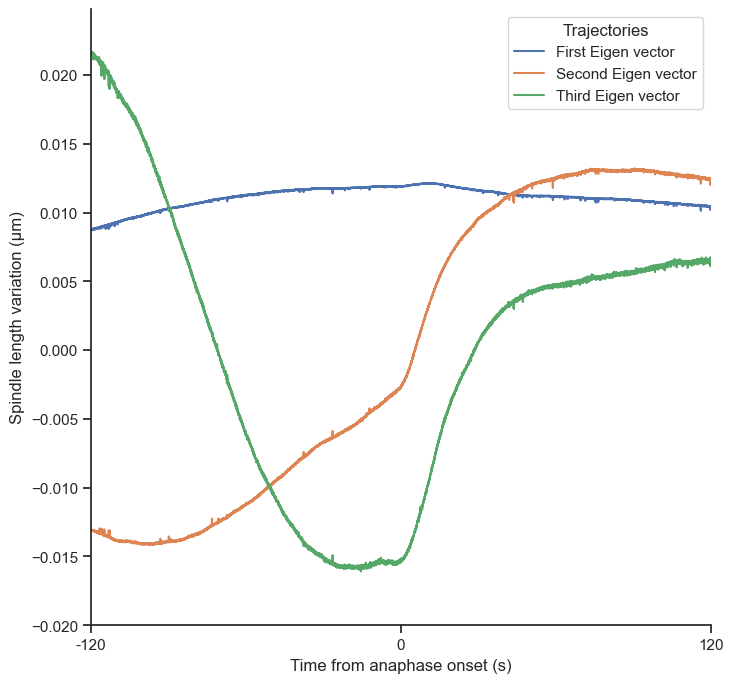

In [48]:
sns.set();
sns.set(rc={"lines.linewidth": 0.8});
sns.set_palette('colorblind',3);
sns.set(font="Arial")
sns.set(font_scale=1)
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
with sns.axes_style("ticks"):
    ev_plot = sns.lineplot(x = "Time", y = "Value", hue = "Trajectories" ,data = ev_spindle_pandas )
    #ev_plot.figure.savefig("ev.eps",format='eps')
    ev_plot.set(xlim=(-120, 120))
    ev_plot.set(ylim=(-0.02, None))
    ev_plot.set_xticks([-120,0,120],labels=['-120','0','120']) 
    ev_plot.set(xlabel="Time from anaphase onset (s)", ylabel="Spindle length variation (µm)")
sns.despine() # to remove axis on right and top
fig = plt.gcf()
plt.show()

## Display conditions with extreme coefficients

In [49]:
score_allConds=allConds.merge(score_spindle.drop(labels=['gene'],axis=1,inplace=False),left_index=True, right_index=True)
pca_avg_per_cond=score_gene.groupby('gene').mean(numeric_only=True)
score_allConds_g=score_allConds.groupby('gene').mean(numeric_only=True)

In [50]:
def plot_extreme_cond(comp,quant_low,quant_high):
    # select extreme cond
    ind_high_axis1 = pca_avg_per_cond[comp] > np.quantile(pca_avg_per_cond[comp],quant_high)
    high1 = pca_avg_per_cond[ind_high_axis1].sort_values(by = "principal component 1")
    display(score_allConds_g[ind_high_axis1].sort_values(by = "principal component 1"))
    ind_low_axis1 = pca_avg_per_cond[comp] < np.quantile(pca_avg_per_cond[comp],quant_low)
    low1 = pca_avg_per_cond[ind_low_axis1].sort_values(by = comp, ascending=False)
    display(score_allConds_g[ind_low_axis1].sort_values(by = "principal component 1"))

    if high1.shape[0]!=2 or low1.shape[0]!=2:
        raise Exception("Other case but 2 genes in extreme case not implemented")

    # Plotting
    print('High coordinate in axis 1')
    sns.set();
    sns.set(rc={"lines.linewidth": 0.5});# mind the order (should be before the palette or color are messed up)

    palettes=('light:blue', 'light:green', 'light:purple', 'light:orange')
    first=True
    Nlh=np.zeros(4, dtype=int)
    goi=high1.index.tolist()+low1.index.tolist()
    for idx,gene in enumerate(goi):
        sel=score_gene["gene"]==gene
        Nlh[idx]= score_gene[sel].shape[0]
        print("n="+str(Nlh[idx]))
        col=sns.color_palette(palette=palettes[idx],n_colors=Nlh[idx])
        print("Gene: "+gene+"  color:"+palettes[idx])
        if first:
            col_all=col
            first=False
        else:
            col_all = col_all + col
    sns.set_palette(col_all) # mind the order (should be after the previous line or color are messed up)
    sns.set(font="Arial")
    sns.set(font_scale=1)

    plt.figure();
    with sns.axes_style("ticks"):
        idx=0
        for gidx,gene in enumerate(goi):
            selec = genef["gene"] == gene
            traj_of_interest = spindlef.loc[ selec]
            traj_smoothed =sg.medfilt(traj_of_interest, [1, sizeK])
            traj_smoothed = pd.DataFrame(np.transpose(traj_smoothed))
            ncurve=0
            for i in range(0,traj_smoothed.shape[1]):
                traj_smoothed_plot = pd.concat([time , traj_smoothed.iloc[:][i]], axis = 1)
                traj_smoothed_plot.columns = ["Time", "Value"]
                traj_smoothed_plot = traj_smoothed_plot.iloc[halfsizeK:-halfsizeK]
                if gidx==0:
                    ls="-"
                elif gidx==1:
                    ls=":"
                elif gidx==2:
                    ls="-."
                else:
                    ls="--"
                graph = sns.lineplot(x = "Time", y = "Value", data = traj_smoothed_plot, linestyle=ls, color=col_all[idx])
                ncurve+=1
                idx+=1
            print("N="+str(ncurve)+" for gene "+gene)
    sns.set(rc={"lines.linewidth": 1.8});
    graph_av = sns.lineplot(x = "Time", y = "Value", data = averageplot_trimmed, color = "black", label = "Average spindle length of the whole dataset");

    sns.despine() # to remove axis on right and top
    fig = plt.gcf()
    graph.set(xlim=(-120, 120))
    graph.set(ylim=(10000, None))
    graph.set_xticks([-120,0,120],labels=['-120','0','120']) 
    graph.set_yticks([0,10000,20000,30000],labels=['0','10','20','30']) 
    graph.set(xlabel="Time from anaphase onset (s)", ylabel="Spindle length variation (µm)")
    fig = plt.gcf()
    plt.show()

pid  principal component 1  principal component 2  \
gene                                                         
spd1  2401.0              96.582189              74.230423   
zen4  1908.0             115.828586             100.836085   

      principal component 3  
gene                         
spd1              21.201080  
zen4              30.114147

pid  principal component 1  principal component 2  \
gene                                                                   
tpxl1-18C  3806.285714            -366.433732             -20.415473   
tpxl1-23C  5790.000000            -326.767092              22.303792   

           principal component 3  
gene                              
tpxl1-18C              62.730110  
tpxl1-23C              48.832743

High coordinate in axis 1
n=7
Gene: spd1  color:light:blue
n=7
Gene: zen4  color:light:green
n=12
Gene: tpxl1-23C  color:light:purple
n=7
Gene: tpxl1-18C  color:light:orange
N=7 for gene spd1
N=7 for gene zen4
N=12 for gene tpxl1-23C
N=7 for gene tpxl1-18C


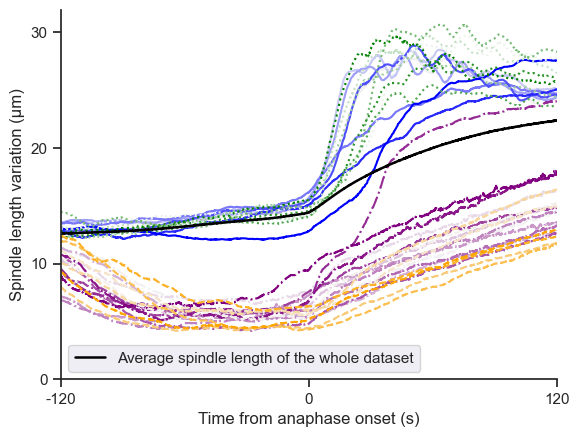

pid  principal component 1  principal component 2  \
gene                                                                  
cls2-23C  4477.571429             -10.207255              81.179557   
zen4      1908.000000             115.828586             100.836085   

          principal component 3  
gene                             
cls2-23C              37.085524  
zen4                  30.114147

pid  principal component 1  principal component 2  \
gene                                                                     
air2gpr1gpr2-15C  4604.0             -10.570989            -113.562660   
air2sep1-15C      4985.0              34.133674             -95.251783   

                  principal component 3  
gene                                     
air2gpr1gpr2-15C               7.403967  
air2sep1-15C                  22.453764

High coordinate in axis 1
n=21
Gene: cls2-23C  color:light:blue
n=7
Gene: zen4  color:light:green
n=11
Gene: air2sep1-15C  color:light:purple
n=9
Gene: air2gpr1gpr2-15C  color:light:orange
N=21 for gene cls2-23C
N=7 for gene zen4
N=11 for gene air2sep1-15C
N=9 for gene air2gpr1gpr2-15C


pid  principal component 1  principal component 2  \
gene                                                                   
tpxl1-18C  3806.285714            -366.433732             -20.415473   
cls2-18C    626.333333              -6.025897              45.276391   

           principal component 3  
gene                              
tpxl1-18C              62.730110  
cls2-18C               50.362488

pid  principal component 1  principal component 2  \
gene                                                             
ani2-23C  5906.0            -143.502267             -13.400456   
ima3-23C  5952.0             -98.429704              30.337331   

          principal component 3  
gene                             
ani2-23C             -49.526393  
ima3-23C             -41.485088

High coordinate in axis 1
n=7
Gene: tpxl1-18C  color:light:blue
n=12
Gene: cls2-18C  color:light:green
n=5
Gene: ima3-23C  color:light:purple
n=12
Gene: ani2-23C  color:light:orange
N=7 for gene tpxl1-18C
N=12 for gene cls2-18C
N=5 for gene ima3-23C
N=12 for gene ani2-23C


In [51]:
plot_extreme_cond(quant_high = 0.99,quant_low = 0.01,comp="principal component 1")
plot_extreme_cond(quant_high = 0.99,quant_low = 0.01,comp="principal component 2")    
plot_extreme_cond(quant_high = 0.99,quant_low = 0.01,comp="principal component 3")    

## Output scores to feed into logistic regression (interacting genes prediction)

In [52]:
g=allConds.drop_duplicates(subset=['gene', 'tempe', 'strain'],keep='first', inplace=False, ignore_index=True)
score_allConds_gg=score_allConds_g.merge(g,how='inner',on='gene').drop(axis=1,labels=['all_exp','pid_x','pid_y'],inplace=False).copy()
for t in ["18C", "23C"]:
  for c in ["principal component 1", "principal component 2", "principal component 3"]:
    pre_n=score_allConds_gg.loc[score_allConds_gg["gene"]==("none-"+t),c]
    if not pre_n.empty:
        n=pre_n.values[0]
        score_allConds_gg.loc[score_allConds_gg["tempe"]==t,c]=(score_allConds_gg.loc[score_allConds_gg["tempe"]==t,c]-n)/n
  if not pre_n.empty:
    score_allConds_gg.loc[score_allConds_gg["tempe"]==t].to_csv('scores_relative_to_none'+t+'.csv', header=True, index=False)
      

## Questioning to which extent the PCA projection recapitulates the trajectories 

In [53]:
# Three components PCA
pca_spindle15 = PCA(n_components=ndim_tot)
res_pca15 = pca_spindle15.fit(spindle_std)
ev_spindle15 = res_pca15.components_.T # Tranposition
score_spindle15 = pd.DataFrame(data = res_pca15.transform(spindle_std))
future_name=dict()
for col in score_spindle15.columns:
    future_name[col]="principal component "+str(col+1)
score_spindle15 = score_spindle15.rename(columns=future_name)
score_spindle15_a = np.array(score_spindle15)


In [54]:
rescaling15 = StandardScaler().fit(spindlef)
proj_all = {}
errs_all = {}
errs_tot = np.zeros((spindlef.shape[0],ndim_tot))
ncond15 = score_spindle15_a.shape[0]
for i in range(0,ndim_tot):
    print("Computing in progress "+str(i+1)+" / "+str(ndim_tot))
    proj_tot = np.transpose(np.tile(rescaling15.mean_, (ncond15,1))) +  ev_spindle15[:,0:i].dot(np.transpose(score_spindle15_a[:,0:i])) * np.sqrt(np.transpose(np.tile(rescaling15.var_, (ncond15,1)))) 
    proj_tot = np.transpose(proj_tot) 
    proj_all[str(i)] = proj_tot
    errs = np.sum(np.power((spindlef - proj_tot), 2), axis = 1)
    errs_tot[:,i] = errs 

Computing in progress 1 / 20
Computing in progress 2 / 20
Computing in progress 3 / 20
Computing in progress 4 / 20
Computing in progress 5 / 20
Computing in progress 6 / 20
Computing in progress 7 / 20
Computing in progress 8 / 20
Computing in progress 9 / 20
Computing in progress 10 / 20
Computing in progress 11 / 20
Computing in progress 12 / 20
Computing in progress 13 / 20
Computing in progress 14 / 20
Computing in progress 15 / 20
Computing in progress 16 / 20
Computing in progress 17 / 20
Computing in progress 18 / 20
Computing in progress 19 / 20
Computing in progress 20 / 20


### Visual inspection of reconstruction on some examples

In [55]:
def testReconstruction(did,name='testing reconstruction ',):
    # Testing the reconstruction
    
    mpl.rcParams['font.family'] ='Arial'
    mpl.rcParams['font.size'] = 8
    mpl.rc('image', cmap='RdYlBu_r')
    mpl.rc('lines', linewidth=0.8)
    plt.style.use('classic')
    index=spindlef.index.get_loc(spindlef[spindlef.index == did].index[0])
    print(allConds.loc[did])
    print('Corresponding to index='+str(index))
    plt.plot(time.values, spindlef.loc[did])
    plt.plot(time.values, proj_all[str(1)][index], label = str(1) + " dimensions")
    plt.plot(time.values, proj_all[str(2)][index], label = str(2) + " dimensions")
    plt.plot(time.values, proj_all[str(3)][index], label = str(3) + " dimensions")
    plt.plot(time.values, proj_all[str(maxdim)][index], label = str(maxdim) + " dimensions")
    plt.legend()
    
    ax = plt.gca()
    ax.set_xlim([-120, 120])
    ax.set_ylim([9000, 25000])
    ax.set_yticks([10000,15000,20000,25000], labels=['10','15','20','25']) 
    ax.set_xticks([-120,0,120],labels=['-120','0','120']) 
    ax.set_xlabel('Time from anaphase onset (s)')
    ax.set_ylabel('Spindle length (µm)')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.show()

In [56]:
testReconstruction(did='ID5257',name='testing reconstruction')

gene       none-18C
tempe           18C
strain         TH27
all_exp        none
pid          2951.0
Name: ID5257, dtype: object
Corresponding to index=203


### Explained variance by each dimension

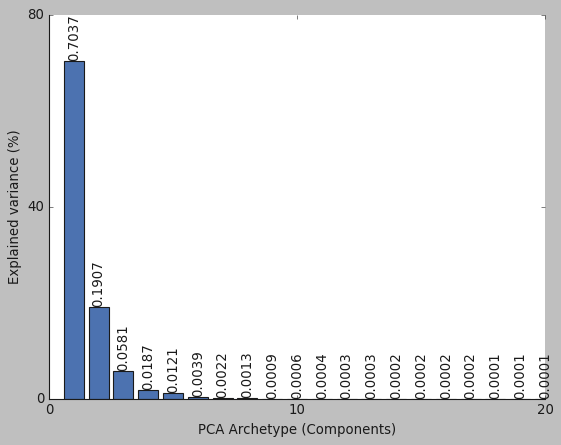

In [57]:
mpl.rcParams['font.family'] ='Arial'
mpl.rcParams['font.size'] = 8
mpl.rc('image', cmap='RdYlBu_r')
mpl.rc('lines', linewidth=0.8)
plt.style.use('classic')

bars = plt.bar(    range(1,len(res_pca15.explained_variance_ratio_)+1),
    res_pca15.explained_variance_ratio_
    )
ax = plt.gca()
ax.bar_label(bars, fmt='%.4f',rotation='vertical')
ax.set_xlim([0, 20])
ax.set_ylim([0, 0.8])
ax.set_yticks([0,0.4,0.8], labels=['0','40','80']) 
ax.set_xticks([0,10,20],labels=['0','10','20']) 
ax.set_xlabel('PCA Archetype (Components)')
ax.set_ylabel('Explained variance (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

### L2 reconstruction error

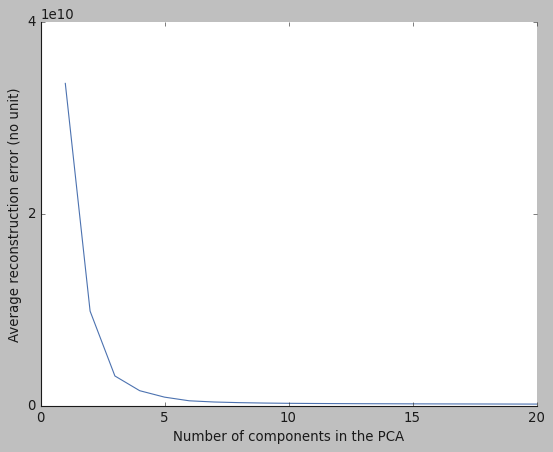

In [58]:
sns.set()
mpl.rcParams['font.family'] ='Arial'
mpl.rcParams['font.size'] = 10
mpl.rc('image', cmap='RdYlBu_r')
mpl.rc('lines', linewidth=1)
plt.style.use('classic')
fig = plt.figure();
plt.plot(range(1,21), np.average(errs_tot, axis = 0))
ax = plt.gca()
ax.set_xlim([0, 20])
ax.set_ylim([0, None])
ax.set_yticks([0,2e10,4e10]) #,labels=['0.0','2.0','4.0']) 
ax.set_xticks([0,5,10,15,20]) #,labels=['0','4.0','8.0']) 
# FIXME axis labels are not displayed for some 
ax.set_xlabel('Number of components in the PCA') 
ax.set_ylabel('Average reconstruction error (no unit)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Robustness of the archetypes

### Variability of the archetypes by bootstrapping 

In [59]:
nboot = 500 # number of bootstrapping iterations
ndim = 3 # number of PCA dimensions
nbsamp = 500 # number of experiments in the dataset upon bootstrapping

In [60]:
nt = time.shape[0]

All_archetypes1 = np.zeros((nboot,nt))
All_archetypes2 = np.zeros((nboot,nt))
All_archetypes3 = np.zeros((nboot,nt))

for i in range(0,nboot):
    subsample_df = spindle_smoothf.sample(n=nbsamp)

    ## Standardization
    subsample_df_std = StandardScaler().fit_transform(subsample_df)

    # Three components PCA
    pca_spindle = PCA(n_components=3)
    res_pca_smooth_sub = pca_spindle.fit(subsample_df_std)

    #print(res_pca_smooth_sub.components_.shape)
    ev_spindle_smooth_sub = res_pca_smooth_sub.components_.T # Tranposition

    score_spindle_smooth_sub = pd.DataFrame(data = res_pca_smooth_sub.transform(subsample_df_std)
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'],
                index=subsample_df.index)
    # %run 'setsigns.ipynb' # Used to fix the sign of the eigen vectors

    res = setsigns(ev_spindle_smooth_sub,score_spindle_smooth_sub,time)
    ev_spindle_smooth_sub = res.tabs
    score_spindle_smooth_sub = res.scores

    All_archetypes1[i,:] = ev_spindle_smooth_sub[:,0]
    All_archetypes2[i,:] = ev_spindle_smooth_sub[:,1]
    All_archetypes3[i,:] = ev_spindle_smooth_sub[:,2]

def errorfill(x, y, yerr, lab, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = 'red'
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, lw = 5, label = lab)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, lw = 2)
    return ax
    #ax.legend(str(lab))

timesboot = time.values.flatten()

all1 = All_archetypes1
all2 = All_archetypes2
all3 = All_archetypes3 #evboot.iloc[2:evboot.shape[0]:5,:]

err_1 = 2*all1.std(axis = 0)
err_2 = 2*all2.std(axis = 0)
err_3 = 2*all3.std(axis = 0)

av1 = np.mean(all1, axis =0)
av2 = np.mean(all2, axis =0)
av3 = np.mean(all3, axis =0)

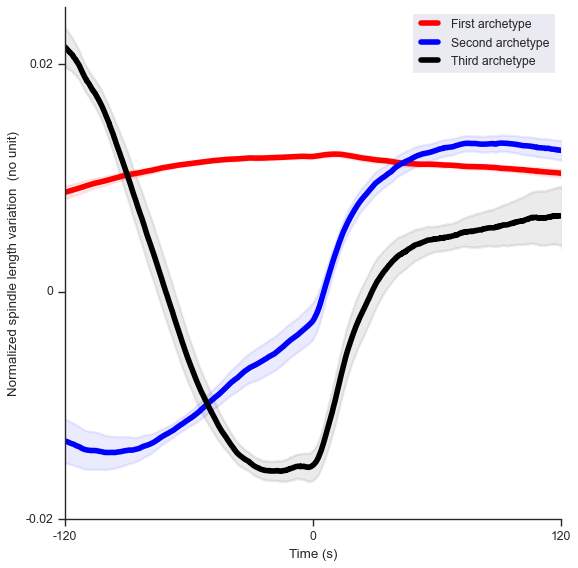

In [61]:
sns.set();
sns.set(rc={"lines.linewidth": 0.8});
sns.set_palette('colorblind',ngff);
sns.set(font="Arial")
sns.set(font_scale=1)

plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
with sns.axes_style("ticks"):
    ax = errorfill(timesboot, av1, err_1, "First archetype", 'red', 0.08)
    errorfill(timesboot,av2, err_2, "Second archetype", 'blue', 0.08, ax=ax)
    graph_av = errorfill(timesboot, av3, err_3, "Third archetype", 'black', alpha_fill = 0.08, ax=ax)
    graph_av.set(xlim=(-120, 120))
    graph_av.set(ylim=(-0.02, None)) # to get autoscale
    graph_av.set_yticks([-0.02,0,0.02],labels=['-0.02','0','0.02']) 
    graph_av.set_xticks([-120,0,120],labels=['-120','0','120']) 
    graph_av.set(xlabel="Time from anaphase onset (s)", ylabel="Normalized spindle length variation  (no unit)")
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
sns.despine() # to remove axis on right and top
plt.show()
#Normalized spindle length variation  (no unit)

### Data subset PCA

In [62]:
def extracted_PCA(data_tot_smooth, geneint=None, tempeint=None,exclude1=None,exclude2=None,geneint2=None,groupint=None):
    # %run 'setsigns.ipynb'
    subset= np.full((1,data_tot_smooth.shape[0]), True)
    # print("subset.shape="+str(subset.shape))
    if (geneint and not geneint2):
        presubset = data_tot_smooth["gene"].map(lambda x:x.startswith(geneint))
        print('Including gene with name starting with ' + geneint)
        subset=np.logical_and(subset,np.asarray(presubset))
    elif (geneint and geneint2):
        presubset = np.logical_or(data_tot_smooth["gene"].map(lambda x:x.startswith(geneint)),
                          np.asarray(data_tot_smooth["gene"].map(lambda x:x.startswith(geneint2))))         
        print('Including gene with name starting with ' + geneint+' or '+geneint2)
        subset=np.logical_and(subset,np.asarray(presubset))
    # print("subset.shape="+str(subset.shape))
    if (tempeint):
        presubset=data_tot_smooth["tempe"] == tempeint
        print('Including conditions with temperature= ' + tempeint)
        subset=np.logical_and(subset,np.asarray(presubset))
    # print("subset.shape="+str(subset.shape))
    if (exclude1 and not exclude2):
        presubset = np.logical_not(data_tot_smooth["gene"].map(lambda x:x.startswith(exclude1)))
        print('Excluding gene with name starting with ' + exclude1)
        subset=np.logical_and(subset,np.asarray(presubset))
    elif (exclude1 and exclude2):
        presubset = np.logical_not(np.logical_or(data_tot_smooth["gene"].map(lambda x:x.startswith(exclude1)),
                          np.asarray(data_tot_smooth["gene"].map(lambda x:x.startswith(exclude2)))))         
        print('Excluding gene with name starting with ' + exclude1+' or '+exclude2)
        subset=np.logical_and(subset,np.asarray(presubset))
    if (groupint):
        dsg=data_tot_smooth.merge(groupOfConds.drop(axis=1,labels='Details',inplace=False),how='left',left_on='gene',right_on='condition')
        # display(dsg)
        presubset = np.asarray(dsg["group"]==groupint)
        subset=np.logical_and(subset,presubset)
    print("Number of embryos ="+str(np.sum(subset)))
    traj_int = data_tot_smooth.loc[subset.flatten()]
    # print(traj_int.shape)
    ## Standardization
    traj_int = traj_int.drop(["gene","tempe"], axis = 1)
    print(traj_int.shape)
    traj_int_std = StandardScaler().fit_transform(traj_int)

    # Three components PCA
    pca_spindle_int = PCA(n_components=3)
    
    res_pca_int = pca_spindle_int.fit(traj_int_std)
    print('Explained variance % '+str(100*res_pca_int.explained_variance_ratio_))
    ev_spindle_int = res_pca_int.components_.T # Tranposition
    score_spindle_int = pd.DataFrame(data = res_pca_int.transform(traj_int_std)
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
   
    # %run 'setsigns.ipynb'
    res = setsigns(ev_spindle_int, score_spindle_int, time)
    res.geneint = geneint
    res.tempeint = tempeint
    res.traj = traj_int
    res.eig = res_pca_int.explained_variance_ratio_
    
    return res

#### non treated versus the whole dataset

In [63]:
print("******************* gene = none *************************")
res1 = extracted_PCA(data_tot_smooth, geneint="none")
print("******************* gene not filtered *************************")
res3 = extracted_PCA(data_tot_smooth)

sns.set();
sns.set(rc={"lines.linewidth": 0.8});
sns.set_palette('colorblind',ngff);
sns.set(font="Arial")
sns.set(font_scale=1)
mpl.rcParams['font.family'] ='Arial'
mpl.rcParams['font.size'] = 8
mpl.rc('image', cmap='RdYlBu_r')
mpl.rc('lines', linewidth=0.8)
plt.style.use('classic')

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time, res1.tabs[:,0], 'r-', linewidth = 5 );
plt.plot(time, res1.tabs[:,1], 'b-', linewidth = 5);
plt.plot(time,res1.tabs[:,2], 'xkcd:black', linewidth = 5);

plt.plot(time,res3.tabs[:,0], 'r--', linewidth = 3)
plt.plot(time,res3.tabs[:,1], 'b--', linewidth = 3)
plt.plot(time,res3.tabs[:,2], 'xkcd:black', linestyle = 'dashed', linewidth = 3)

ax = plt.gca()

ax.set(xlim=(-120, 120))
ax.set(ylim=(-0.02, None))
ax.set_xticks([-120,0,120],labels=['-120','0','120']) 
ax.set_yticks([-0.02,0,0.02],labels=['-0.02','0','0.02']) 
ax.set(xlabel="Time from anaphase onset (s)", ylabel="Normalized spindle length variation  (no unit)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if res1.geneint == "none":
    res1.geneint = "non treated"
    
plt.legend(('First eigen vector - ' +  res1.geneint , 
            'Second eigenvector - ' +  res1.geneint,
            'Third eigenvector - ' +  res1.geneint,
            'First eigen vector - Whole dataset', 
            'Second eigen vector - Whole dataset',
            'Third eigen vector - Whole dataset'))

plt.show();

******************* gene = none *************************
Including gene with name starting with none
Number of embryos =129
(129, 8233)
Explained variance % [72.9020918  14.49773823  6.39278247]
******************* gene not filtered *************************
Number of embryos =1618
(1618, 8233)
Explained variance % [70.6337534  19.16403352  5.83422867]


In [64]:
#### Comparing non treated at two temperatures

******************* gene = none 18C *************************
Including gene with name starting with none
Including conditions with temperature= 18C
Number of embryos =58
(58, 8233)
Explained variance % [52.03215998 28.31457804 10.6120902 ]
******************* gene = none 23C *************************
Including gene with name starting with none
Including conditions with temperature= 23C
Number of embryos =71
(71, 8233)
Explained variance % [71.47962226 15.30633389  6.60755758]
******************* gene = not filtered *************************
Number of embryos =1618
(1618, 8233)
Explained variance % [70.6337534  19.16403352  5.83422867]


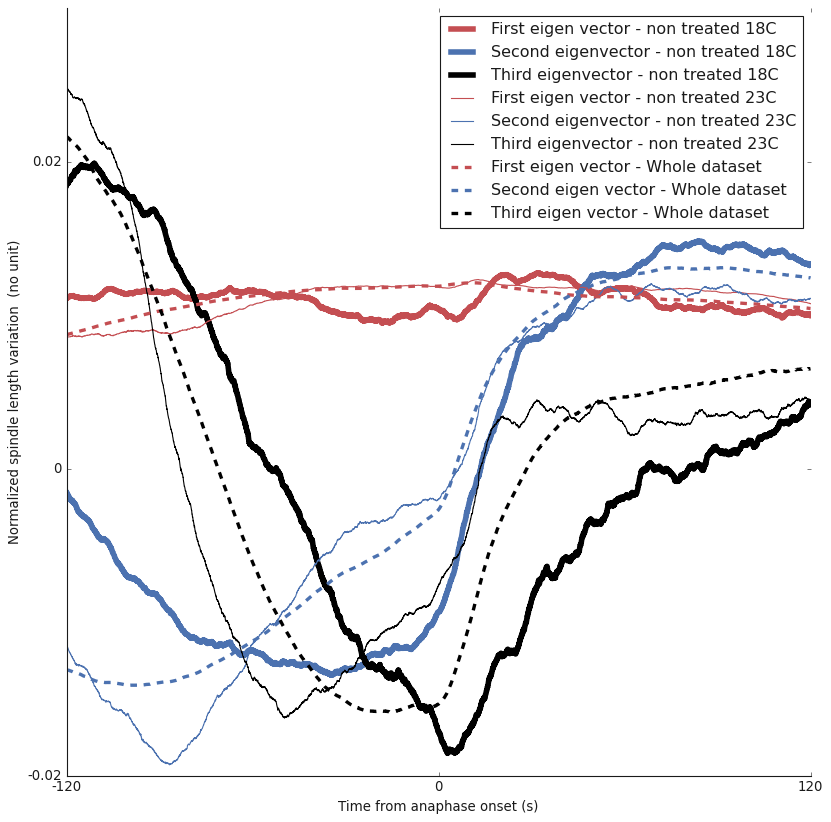

In [65]:
print("******************* gene = none 18C *************************")
res1 = extracted_PCA(data_tot_smooth, "none", "18C")
print("******************* gene = none 23C *************************")
res2 = extracted_PCA(data_tot_smooth, "none", "23C")
print("******************* gene = not filtered *************************")
res3 = extracted_PCA(data_tot_smooth)

sns.set()
sns.set(rc={"lines.linewidth": 0.8});
sns.set_palette('colorblind',ngff);
sns.set(font="Arial")
sns.set(font_scale=1)
mpl.rcParams['font.family'] ='Arial'
mpl.rcParams['font.size'] = 8
mpl.rc('image', cmap='RdYlBu_r')
mpl.rc('lines', linewidth=0.8)
plt.style.use('classic')

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time, res1.tabs[:,0], 'r-', linewidth = 5 );
plt.plot(time, res1.tabs[:,1], 'b-', linewidth = 5);
plt.plot(time,res1.tabs[:,2], 'xkcd:black', linewidth = 5);

plt.plot(time, res2.tabs[:,0], 'r-');
plt.plot(time, res2.tabs[:,1], 'b-');
plt.plot(time,res2.tabs[:,2], 'xkcd:black');

plt.plot(time,res3.tabs[:,0], 'r--', linewidth = 3)
plt.plot(time,res3.tabs[:,1], 'b--', linewidth = 3)
plt.plot(time,res3.tabs[:,2], 'xkcd:black', linestyle = 'dashed', linewidth = 3)

ax = plt.gca()

ax.set(xlim=(-120, 120))
ax.set(ylim=(-0.02, None))
ax.set_xticks([-120,0,120],labels=['-120','0','120']) 
ax.set_yticks([-0.02,0,0.02],labels=['-0.02','0','0.02']) 
ax.set(xlabel="Time from anaphase onset (s)", ylabel="Normalized spindle length variation  (no unit)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if (not res2.tempeint):
    tempeintlabel = ''
else :
    tempeintlabel = res2.tempeint 
    
if (not res1.tempeint):
    tempereflabel = ''
else :
    tempereflabel = res1.tempeint

if res1.geneint == "none":
    res1.geneint = "non treated"
    
if res2.geneint == "none":
    res2.geneint = "non treated"
    
plt.legend(('First eigen vector - ' +  res1.geneint + ' ' + tempereflabel , 
            'Second eigenvector - ' +  res1.geneint + ' ' + tempereflabel ,
            'Third eigenvector - ' +  res1.geneint + ' ' + tempereflabel ,
            'First eigen vector - ' +  res2.geneint + ' ' + tempeintlabel ,
            'Second eigenvector - ' +  res2.geneint + ' ' + tempeintlabel ,
            'Third eigenvector - ' +  res2.geneint + ' ' + tempeintlabel, 
            'First eigen vector - Whole dataset', 
            'Second eigen vector - Whole dataset',
            'Third eigen vector - Whole dataset'))

plt.show()

# PCA as quantitative phenotype
## Variability of PCA coefficients from PCA of embryos treated similarly

In [66]:
# conditions of interest for our assay
genesint = ["none-18C", "none-23C", "tpxl1-18C", "tpxl1-23C", "gpr1gpr2-18C", "air2gpr1gpr2-15C", "air2sep1-15C", "zen4", "spd1",
            "dyci1", "air1", "cls2-18C", "cls2-23C","ani2-23C","ima3-23C", "air2-15C", "air2-25C", "klp19", "L4440-18C","L4440-23C"]

# filter also on the strains
strainint="TH27"
strainint2="JEP31"


#### data shaping

In [67]:
score_spindle_tot = pd.concat([tempef, strainf, score_spindle], axis = 1) # note that gene is already in score_spindle

#### label the data and display associated colors

python(34922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


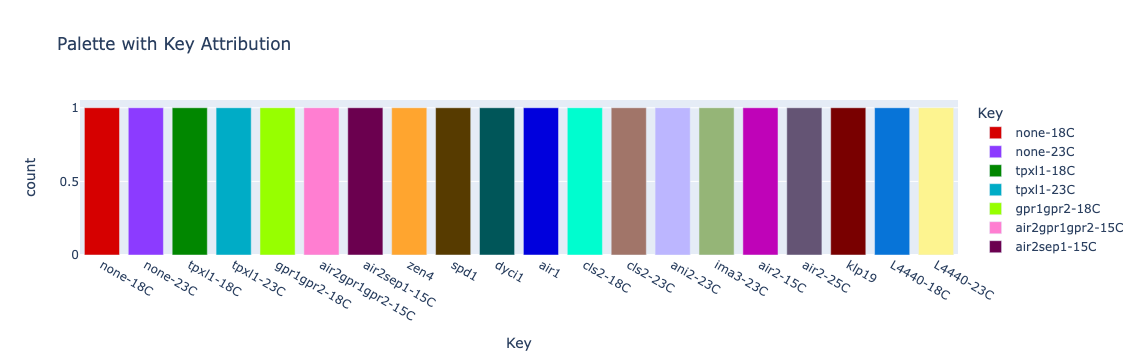

In [68]:
for g in genesint:
    if not g in score_spindle_tot["gene"].values:
        print("I cannot find condition:"+g)
color_labels = genesint
rgb_values = cc.glasbey[:len(genesint)] # colors are already in hex
color_map=dict(zip(color_labels,rgb_values))
pxcolor_map=color_map
databars = {'Key': list(color_map.keys()), 'Color': list(color_map.values())} #, 'Y':np.ones(len(color_map))}
dfbars = pd.DataFrame(databars)
fig =px.bar(dfbars, x='Key', color='Key', color_discrete_map=pxcolor_map,
             title='Palette with Key Attribution')
fig.show()

### plot the coefficients of single embryos to highlight clustering
#### 2D projections

Gene: none-18C Number of embryos =58
Gene: none-23C Number of embryos =71
Gene: tpxl1-18C Number of embryos =7
Gene: tpxl1-23C Number of embryos =12
Gene: gpr1gpr2-18C Number of embryos =8
Gene: air2gpr1gpr2-15C Number of embryos =9
Gene: air2sep1-15C Number of embryos =11
Gene: zen4 Number of embryos =7
Gene: spd1 Number of embryos =7
Gene: dyci1 Number of embryos =6
Gene: air1 Number of embryos =7
Gene: cls2-18C Number of embryos =12
Gene: cls2-23C Number of embryos =21
Gene: ani2-23C Number of embryos =12
Gene: ima3-23C Number of embryos =5
Gene: air2-15C Number of embryos =8
Gene: air2-25C Number of embryos =3
Gene: klp19 Number of embryos =10
Gene: L4440-18C Number of embryos =63
Gene: L4440-23C Number of embryos =97
Considered 20 conditions


Gene: none-18C Number of embryos =58
Gene: none-23C Number of embryos =71
Gene: tpxl1-18C Number of embryos =7
Gene: tpxl1-23C Number of embryos =12
Gene: gpr1gpr2-18C Number of embryos =8
Gene: air2gpr1gpr2-15C Number of embryos =9
Gene: air2sep1-15C Number of embryos =11
Gene: zen4 Number of embryos =7
Gene: spd1 Number of embryos =7
Gene: dyci1 Number of embryos =6
Gene: air1 Number of embryos =7
Gene: cls2-18C Number of embryos =12
Gene: cls2-23C Number of embryos =21
Gene: ani2-23C Number of embryos =12
Gene: ima3-23C Number of embryos =5
Gene: air2-15C Number of embryos =8
Gene: air2-25C Number of embryos =3
Gene: klp19 Number of embryos =10
Gene: L4440-18C Number of embryos =63
Gene: L4440-23C Number of embryos =97
Considered 20 conditions


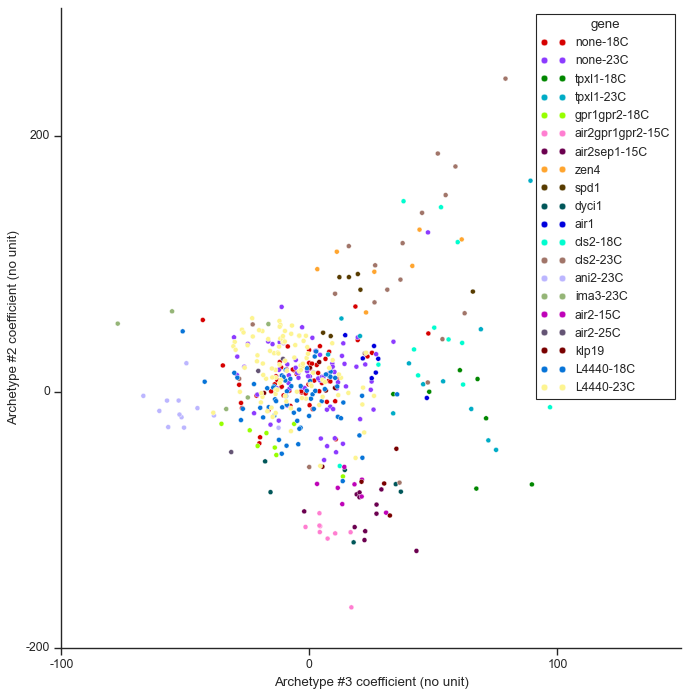

Gene: none-18C Number of embryos =58
Gene: none-23C Number of embryos =71
Gene: tpxl1-18C Number of embryos =7
Gene: tpxl1-23C Number of embryos =12
Gene: gpr1gpr2-18C Number of embryos =8
Gene: air2gpr1gpr2-15C Number of embryos =9
Gene: air2sep1-15C Number of embryos =11
Gene: zen4 Number of embryos =7
Gene: spd1 Number of embryos =7
Gene: dyci1 Number of embryos =6
Gene: air1 Number of embryos =7
Gene: cls2-18C Number of embryos =12
Gene: cls2-23C Number of embryos =21
Gene: ani2-23C Number of embryos =12
Gene: ima3-23C Number of embryos =5
Gene: air2-15C Number of embryos =8
Gene: air2-25C Number of embryos =3
Gene: klp19 Number of embryos =10
Gene: L4440-18C Number of embryos =63
Gene: L4440-23C Number of embryos =97
Considered 20 conditions


In [69]:
dims = [(1,2), (3,2), (1,3)]
for di, d in enumerate(dims):
    sns.set();
    sns.set(rc={"lines.linewidth": 0.8});
    sns.set(font="Arial")
    sns.set(font_scale=1)
    plt.figure(figsize=(10, 10))
    # score_int = score_spindle_tot.loc[ gene["gene"] == "none"]
    # score_int["gene"] = np.repeat("WT", score_int.shape[0])
    with sns.axes_style("ticks"):
        for idx, gene_cur in enumerate(genesint):
            # selec=np.logical_and(score_spindle_tot["gene"] == gene_cur, np.asarray(np.logical_and(score_spindle_tot["tempe"] == tempeint, score_spindle_tot["strain"] == strainint)))
            selec=np.logical_and(score_spindle_tot["gene"] == gene_cur,
                                 np.asarray( np.logical_or(score_spindle_tot["strain"] == strainint,np.asarray(score_spindle_tot["strain"] == strainint2))))
            print("Gene: "+gene_cur+" Number of embryos ="+str(np.sum(selec)))
            if idx==0:
                score_int = score_spindle_tot.loc[selec]
            else:
                score_int = pd.concat([score_int, score_spindle_tot.loc[ selec]], axis = 0)
        print("Considered "+str(len(genesint))+ " conditions")
        sns_plot = sns.scatterplot(x = "principal component "+str(d[0]), y = "principal component "+str(d[1]),hue='gene',
                                   data = score_int,palette=color_map)
        graph_av=sns_plot
        if di==0:
            graph_av.set(xlim=(-500, 300))
            graph_av.set(ylim=(-200, 300)) 
            graph_av.set_yticks([-200,0,200],labels=['-200','0','200']) 
            graph_av.set_xticks([-300,0,300],labels=['-300','0','300']) 
        elif di==1:
            graph_av.set(xlim=(-100, 150))
            graph_av.set(ylim=(-200, 300)) 
            graph_av.set_yticks([-200,0,200],labels=['-200','0','200']) 
            graph_av.set_xticks([-100,0,100],labels=['-100','0','100']) 
        else:
            graph_av.set(xlim=(-500, 300))
            graph_av.set(ylim=(-100, 150)) 
            graph_av.set_yticks([-100,0,100],labels=['-100','0','100']) 
            graph_av.set_xticks([-300,0,300],labels=['-300','0','300'])             
        graph_av.set(xlabel="Archetype #"+str(d[0])+" coefficient (no unit)", ylabel="Archetype #"+str(d[1])+" coefficient (no unit)")
    sns.despine() # to remove axis on right and top
    plt.show()

#### 3D representation

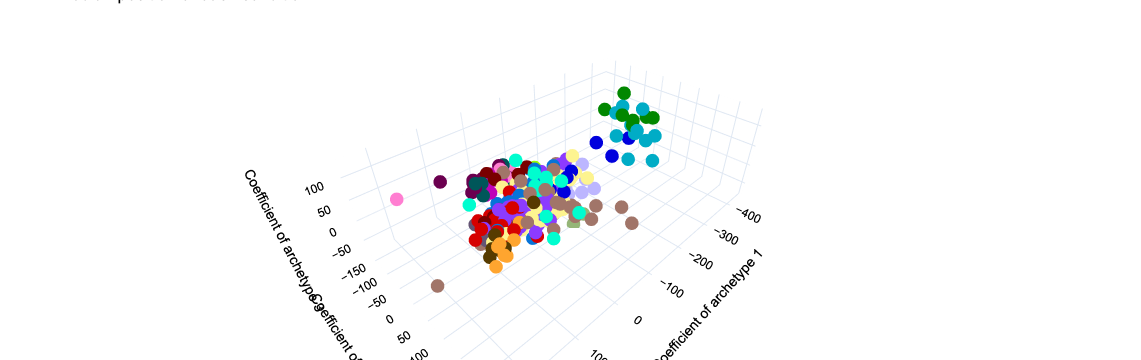

In [70]:
fig = px.scatter_3d(score_int, x="principal component 1", y="principal component 2",z="principal component 3", text=None, 
                        color='gene',color_discrete_map=pxcolor_map)
dummy=fig.update_traces(textposition='top center')
dummy=fig.update_layout(title="PCA Map 3D",
    template='plotly_white',
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black",
    title_text='Median position of each condition',
    margin=dict(l=0, r=0, b=0, t=0),
    showlegend=False
)
dummy=fig.update_scenes(xaxis_title_font_family="Arial",xaxis_title_text="Coefficient of archetype 1",  
                  yaxis_title_font_family="Arial",yaxis_title_text="Coefficient of archetype 2",  
                  zaxis_title_font_family="Arial",zaxis_title_text="Coefficient of archetype 3")
# tight layout
marginInches = 0#1/18
ppi = 300
ppi_screen = 72
width_inches = 6*8.5/2.54
height_inches = 6*8.5/2.54

fig.show()

## Comparing conditions from related mechanisms

#### Data shaping

In [71]:
condsDetails=groupOfConds.loc[groupOfConds["Details"].notnull()].drop(labels="condition",inplace=False,axis=1)

In [72]:
posM = score_spindle_tot.groupby("gene",as_index=False).median(numeric_only=True).copy()
posM=posM.merge(groupOfConds.drop(labels='Details',axis=1,inplace=False),how='left',left_on='gene',right_on='condition')
posM.drop(labels='condition',axis=1,inplace=True)

spindlefgene=spindlef.merge(genef,how='inner',left_index=True,right_index=True)
spindlefg=spindlefgene.groupby("gene",as_index=False).mean(numeric_only=True).copy()
spindlefg=spindlefg.merge(groupOfConds.drop(labels='Details',axis=1,inplace=False),how='left',left_on='gene',right_on='condition').drop(labels='condition',axis=1,inplace=False)
spindlefgg=spindlefg.groupby("group",as_index=False).median(numeric_only=True)

posMg=posM.groupby("group",as_index=False).median(numeric_only=True)

/var/folders/rh/qywtqnw925n8ms_lmg7rmxn40000gn/T/ipykernel_27742/628794978.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



#### Palette for showing conditions

{'spn': '#d60000',
 'kt': '#8c3bff',
 'ctrl': '#018700',
 'ckn': '#00acc6',
 'traf': '#97ff00',
 'size': '#ff7ed1',
 'kt+fgc': '#6b004f',
 'nop': '#ffa52f',
 'fgc': '#573b00',
 'map': '#005659',
 'cc': '#0000dd',
 'ori': '#00fdcf',
 'pol': '#a17569'}

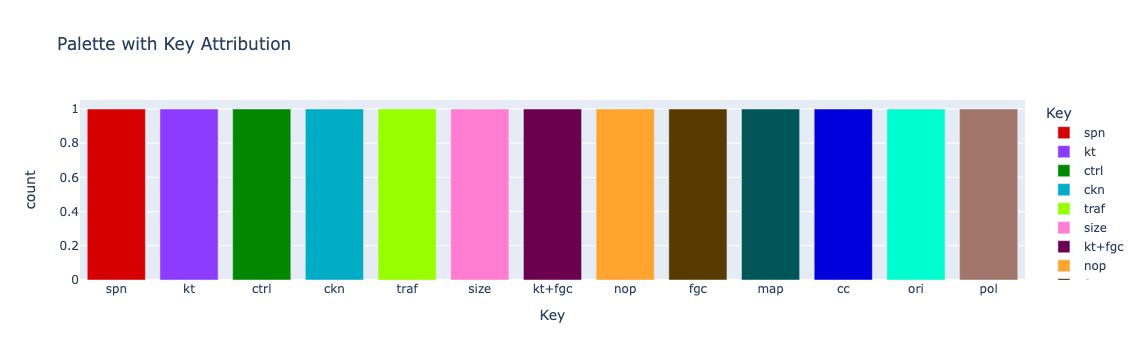

In [73]:
rgb_values = cc.glasbey[:condsDetails.shape[0]] # colors are already in hex
color_map_grp=dict(zip(condsDetails["group"].to_list(),rgb_values))
pxcolor_map_grp=color_map_grp
display(color_map_grp)
databars_grp = {'Key': list(color_map_grp.keys()), 'Color': list(color_map_grp.values())}
dfbars_grp = pd.DataFrame(databars_grp)
fig_grp = px.bar(dfbars_grp, x='Key', color='Key', color_discrete_map=pxcolor_map_grp,
             title='Palette with Key Attribution')
fig_grp.show()

#### Plotting average length per group

=> Included group cc
=> Included group ckn
=> Included group ctrl
=> Included group fgc
=> Included group kt
=> Included group kt+fgc
=> Included group map
=> Included group nop
=> Included group ori
=> Included group pol
=> Included group size
=> Included group spn
=> Included group traf
13 to display
0 excluded
TOTAL conditions: 13


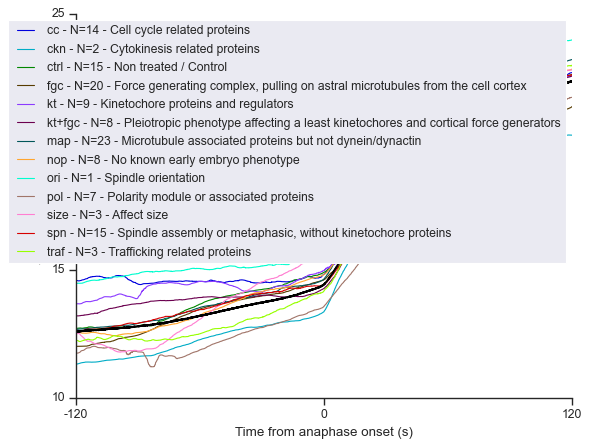

In [74]:
grpN=spindlefg.groupby('group').count()["gene"].copy()

sns.set()
sns.set(font="Arial")
sns.set(font_scale=8)
sns.set(rc={"lines.linewidth": 1});

plt.figure();

with sns.axes_style("ticks"):
    ncurve = 0
    nexcl = 0
    for g in spindlefgg["group"]:
        selec = spindlefgg["group"]==g
        s=spindlefgg.drop(inplace=False,axis=1,labels='group')
        traj_of_interest = s.loc[selec]
        traj_smoothed =sg.medfilt(traj_of_interest, [1, sizeK])
        av_traj = traj_smoothed
        traj_cur = pd.DataFrame(np.transpose(av_traj))
        traj_plot = pd.concat([time , traj_cur], axis = 1)
        traj_plot.columns = ["Time", "Value"]
        traj_plot = traj_plot.iloc[halfsizeK:-halfsizeK]
        graph = sns.lineplot(x = "Time", y = "Value", data = traj_plot,
                             label=g+' - N='+str(grpN.loc[g]) + ' - ' +str(condsDetails.loc[condsDetails['group']==g,'Details'].values[0]),
                             color=pxcolor_map_grp[g]);
        ncurve+=1
        print('=> Included group ' + str(g))
    sns.set(rc={"lines.linewidth": 1.8});
    graph_av = sns.lineplot(x = "Time", y = "Value", data = averageplot_trimmed, color = "black") #, label = "Average spindle length of the whole dataset");
    print(str(ncurve) + " to display")
    print(str(nexcl) + " excluded")
    print("TOTAL conditions: "+str(ncurve+nexcl))

    graph_av.set(xlim=(-120, 120))
    graph_av.set(ylim=(10000, None))
    graph_av.set_xticks([-120,0,120],labels=['-120','0','120']) 
    graph_av.set_yticks([10000,15000,20000,25000],labels=['10','15','20','25']) 
    graph_av.set(xlabel="Time from anaphase onset (s)", ylabel="Spindle length (µm)")
sns.despine()
plt.show()

#### Plotting helper

In [75]:
def plot_helper(lposM,di,logAxes=False,factor=1,tag='',color='gene',palette='tab10',t=None,symbol=0):    
    if logAxes:
        fig = px.scatter(lposM, x="principal component "+str(di[0]), y="principal component "+str(di[1]), text=t, 
                    color=color,color_discrete_map=palette, log_x=True, log_y=True)
    else:
        fig = px.scatter(lposM, x="principal component "+str(di[0]), y="principal component "+str(di[1]), text=t, 
                    color=color,color_discrete_map=palette)#, log_x=True, log_y=True)
    fig.update_traces(
        marker=dict(size=8, symbol=symbol),
        selector=dict(mode="markers"),
    )
    dummy=fig.update_traces(textposition='middle left')
    dummy=fig.update_layout(title="PCA Map "+str(di),
                  template='simple_white')
    #fig.update_xaxes(range=[-0.8, 0.8])
    #fig.update_yaxes(range=[-0.8, 0.8])
    if di==(1,2):
        fig.update_xaxes(range=[-350, 200])
        fig.update_yaxes(range=[-125, 125])
        fig.update_xaxes(tickvals=[-200, 0, 200], ticktext=['-200', '0', '200'] )
        fig.update_yaxes(tickvals=[-100, 0, 100], ticktext=['-100', '0', '100'] )
    elif di==(3,2):
        fig.update_xaxes(range=[-75, 75])
        fig.update_yaxes(range=[-125, 125])
        fig.update_xaxes(tickvals=[-50, 0, 50], ticktext=['-50', '0', '50'] )
        fig.update_yaxes(tickvals=[-100, 0, 100], ticktext=['-100', '0', '100'] )
    else:
        fig.update_xaxes(range=[-350, 200])
        fig.update_yaxes(range=[-75, 75])
        fig.update_xaxes(tickvals=[-200, 0, 200], ticktext=['-200', '0', '200'] )
        fig.update_yaxes(tickvals=[-50, 0, 50], ticktext=['-50', '0', '50'] )             
    dummy=fig.update_layout(
        font_family="Arial",
        font_color="black",
        title_font_family="Arial",
        title_font_color="black",
        legend_title_font_color="black",
        title_text='Median position of each condition'
    )
    dummy=fig.update_xaxes(title_font_family="Arial")
    dummy=fig.update_xaxes(title_text="Coefficient of archetype "+str(di[0])) 
    dummy=fig.update_yaxes(title_font_family="Arial")
    dummy=fig.update_yaxes(title_text="Coefficient of archetype "+str(di[1])) 
    dummy=fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    dummy=fig.update_layout(showlegend=False)
    fig.show()
    
def plot_helper_3D(lposM,tag='',color='gene',palette='tab10'):
    fig = px.scatter_3d(lposM, x="principal component 1", y="principal component 2",z="principal component 3", text="gene", 
                        color=color,color_discrete_map=palette)
                        #log_x=True, size_max=60)
    dummy=fig.update_traces(textposition='top center')
    dummy=fig.update_layout(title="PCA Map 3D",
        template='plotly_white',
        font_family="Arial",
        font_color="black",
        title_font_family="Arial",
        title_font_color="black",
        legend_title_font_color="black",
        title_text='Median position of each condition',
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False
    )
    dummy=fig.update_scenes(xaxis_title_font_family="Arial",xaxis_title_text="Coefficient of archetype 1",  
                      yaxis_title_font_family="Arial",yaxis_title_text="Coefficient of archetype 2",  
                      zaxis_title_font_family="Arial",zaxis_title_text="Coefficient of archetype 3")
    fig.show()
    

#### Plot individual conditions

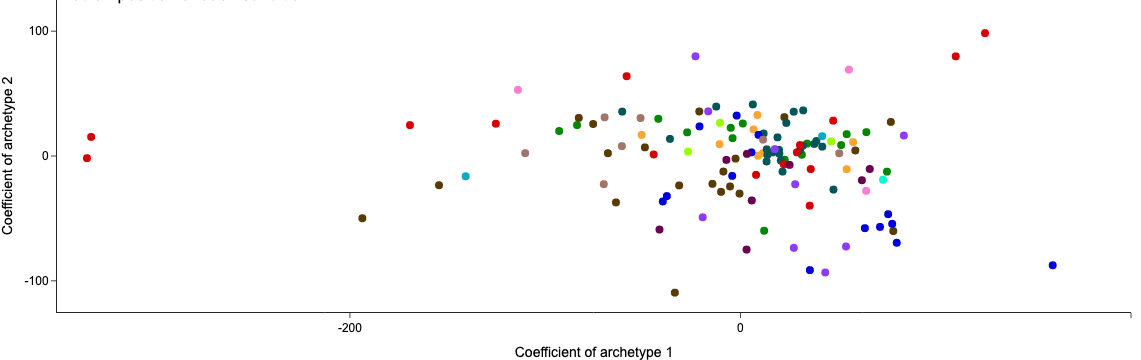

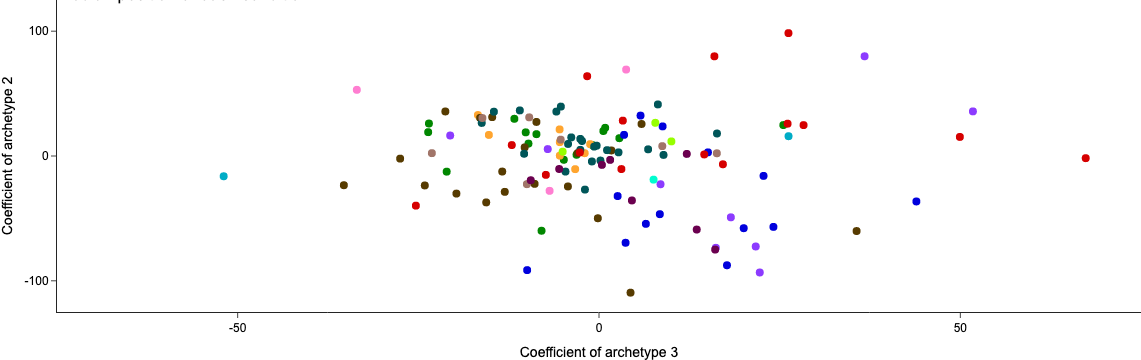

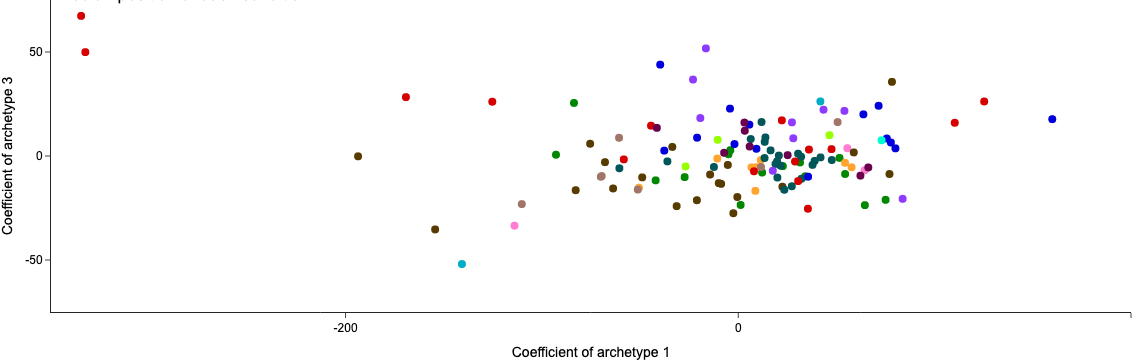

In [76]:
plot_helper(posM,(1,2),tag='_grp_',color='group',palette=pxcolor_map_grp,t=None)
plot_helper(posM,(3,2),tag='_grp_',color='group',palette=pxcolor_map_grp,t=None)
plot_helper(posM,(1,3),tag='_grp_',color='group',palette=pxcolor_map_grp,t=None)

#### Plot the average of each group

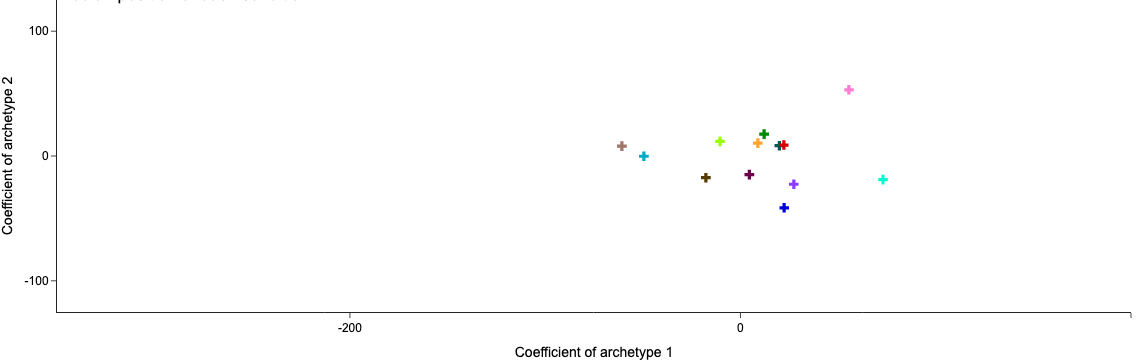

In [77]:
plot_helper(posMg,(1,2),tag='_grp_grp_',color='group',palette=pxcolor_map_grp,t=None,symbol=3)
plot_helper(posMg,(3,2),tag='_grp_grp_',color='group',palette=pxcolor_map_grp,t=None,symbol=3)
plot_helper(posMg,(1,3),tag='_grp_grp_',color='group',palette=pxcolor_map_grp,t=None,symbol=3)

#### One can also consider the alternative with the gene names although it appears too crowded somewhat

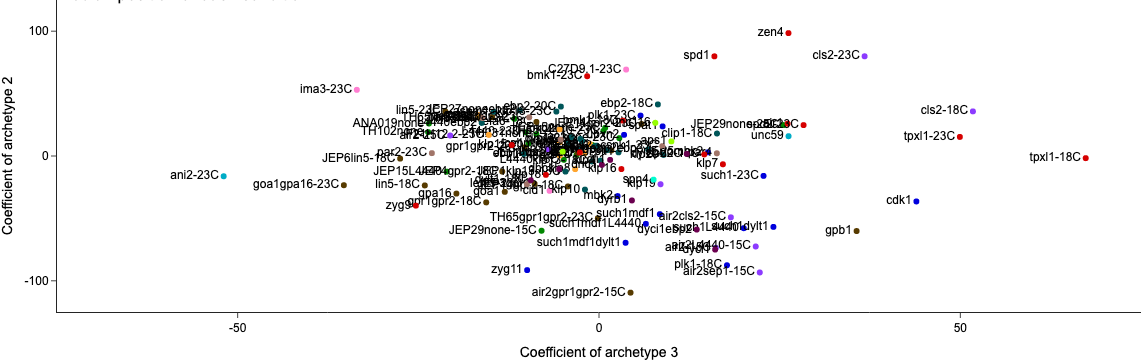

In [78]:
plot_helper(posM,(1,2),tag='_grp_',color='group',palette=pxcolor_map_grp,t='gene')
plot_helper(posM,(3,2),tag='_grp_',color='group',palette=pxcolor_map_grp,t='gene')
plot_helper(posM,(1,3),tag='_grp_',color='group',palette=pxcolor_map_grp,t='gene')

#### Finaly the plot in 3D for each condition

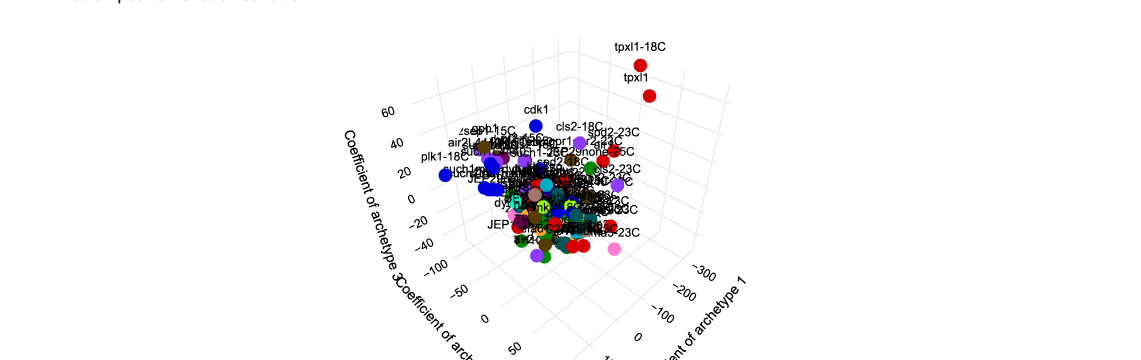

In [79]:
plot_helper_3D(posM,tag='_grp_',color='group',palette=pxcolor_map_grp)

### Clustering statistics
#### Statistics

In [80]:
for d in range(3):
    v="principal component "+str(d+1)
    print(v)
    # for name, group in posM.groupby("group"):
    #     print(group[v].values)
    #display([group[v].values for name, group in posM.groupby("group")])
    display(sp.stats.kruskal(*[group[v].values for name, group in posM.groupby("group")]))

principal component 1


KruskalResult(statistic=17.92533843257985, pvalue=0.11797638057225926)

principal component 2


KruskalResult(statistic=28.661013171172556, pvalue=0.004422856760243982)

principal component 3


KruskalResult(statistic=39.94418159526617, pvalue=7.345900951223897e-05)

#### Bootstrap testing the significance of these clusterings

In [81]:
shuffling_count=10000
HpDistboot = np.zeros((shuffling_count,6)) # for 2 or 3 dim
posMpreshuffled=score_spindle_tot.groupby("gene",as_index=False).median(numeric_only=True)
gocshuffled=groupOfConds.drop(labels=['condition','Details'],axis=1,inplace=False)
gocshuffled.reset_index(drop=True,inplace=True)
i=0

while i <shuffling_count:
    gs=gocshuffled.sample(frac=1, ignore_index=True,random_state=np.random.default_rng())
    posMgs=pd.concat([gs, posMpreshuffled],axis=1)
    for d in range(3):
        v="principal component "+str(d+1)
        (H,p)=sp.stats.kruskal(*[group[v].values for name, group in posMgs.groupby("group")])
        HpDistboot[i,0+2*d]=H
        HpDistboot[i,1+2*d]=p
    i+=1

********************** Dimension 1 **********************
----------------- Histogram on H showing distribution upon shuffing labels ------------


/var/folders/rh/qywtqnw925n8ms_lmg7rmxn40000gn/T/ipykernel_27742/2738323545.py:17: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




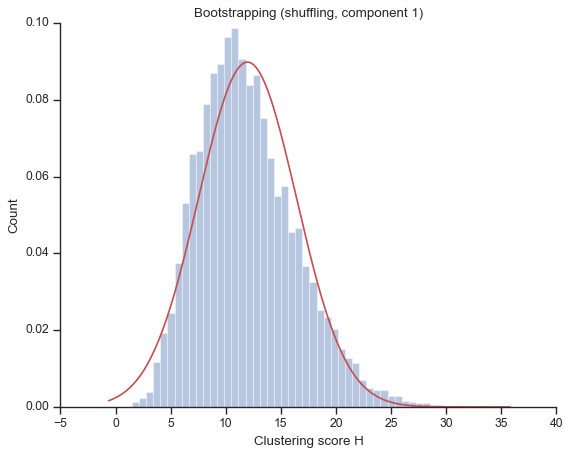

Is there Nan in the Series


False

mean H =11.971518266632604  SD H =4.442661297026079
(11.971518266632579, 11.97151826663263)
----------------- Histogram on p showing distribution upon shuffing labels ------------


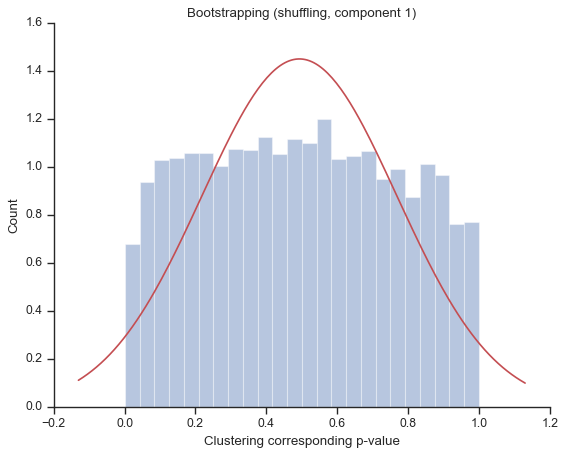

Is there Nan in the Series


False

mean p =0.4936133086725535  SD p =0.27514179399651134
(0.4936133086725534, 0.4936133086725536)
********************** Dimension 2 **********************
----------------- Histogram on H showing distribution upon shuffing labels ------------


Is there Nan in the Series


False

mean H =11.949518783030934  SD H =4.44687210665189
(11.949518783030909, 11.94951878303096)
----------------- Histogram on p showing distribution upon shuffing labels ------------


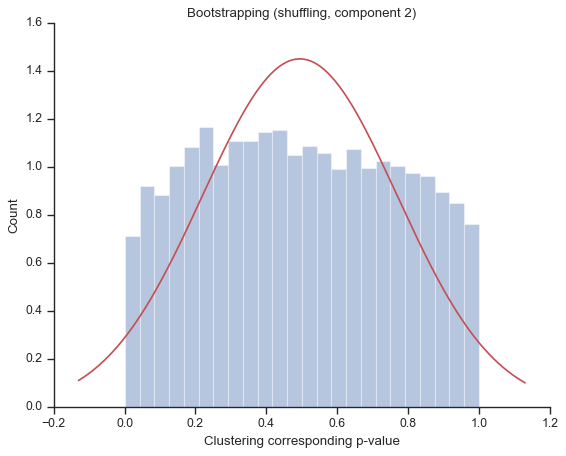

Is there Nan in the Series


False

mean p =0.4948262255862569  SD p =0.2751060760018571
(0.4948262255862568, 0.494826225586257)
********************** Dimension 3 **********************
----------------- Histogram on H showing distribution upon shuffing labels ------------


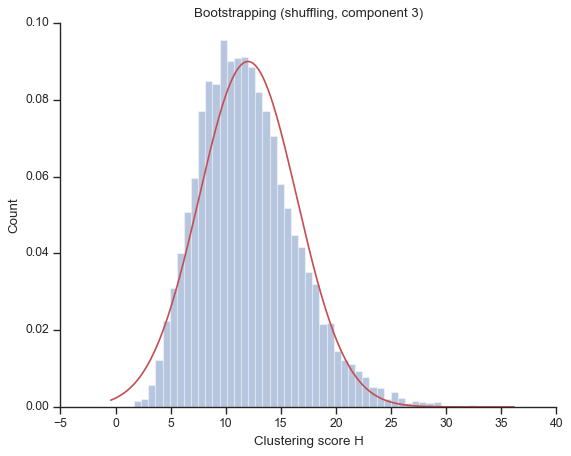

Is there Nan in the Series


False

mean H =12.013941842008132  SD H =4.434399126952258
(12.013941842008107, 12.013941842008158)
----------------- Histogram on p showing distribution upon shuffing labels ------------


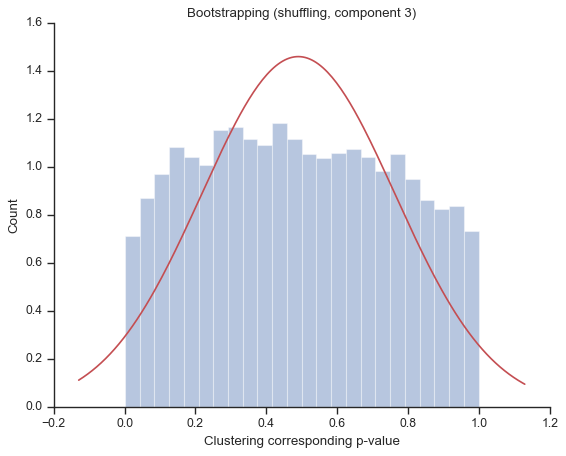

Is there Nan in the Series


False

mean p =0.4905181976384778  SD p =0.27330519780302626
(0.4905181976384777, 0.4905181976384779)


In [82]:
alpha = 0.000000000000001

for d in range(3):
    print("********************** Dimension "+str(d+1)+ " **********************")
    for va in range(2):
        if va==0:
            vas='H'
        else:
            vas='p'
        print("----------------- Histogram on "+vas+" showing distribution upon shuffing labels ------------")
        sns.set()
        sns.set(rc={"lines.linewidth": 0.8});
        sns.set(font="Arial")
        sns.set(font_scale=1)
        plt.figure();
        with sns.axes_style("ticks"):
            graph_av = sns.distplot(HpDistboot[:,2*d+va].flatten() , kde = False, fit = sp.stats.norm, fit_kws={"color":"r"})
            # graph_av.set(xlim=(0.05, 0.15))
            # graph_av.set(ylim=(0, None)) # to get autoscale
            # graph_av.set_yticks([0,20,40],labels=['0','20','40']) /
            # graph_av.set_xticks([0.05,0.1,0.15],labels=['0.05','0.10','0.15']) 
            if va==0:
                graph_av.set(xlabel="Clustering score H", ylabel="Count")
            else:
                graph_av.set(xlabel="Clustering corresponding p-value", ylabel="Count")
        sns.despine() # to remove axis on right and top
        plt.title("Bootstrapping (shuffling, component "+str(d+1)+")")
        plt.show()
    
        print("Is there Nan in the Series")
        display(any(np.isnan(HpDistboot[:,2*d+0].flatten())))
        print("mean "+vas+" ="+str(np.mean(HpDistboot[:,2*d+va].flatten()))+"  SD "+vas+" ="+str(np.std(HpDistboot[:,2*d+va].flatten())))
        print(sp.stats.norm.interval(alpha, loc=np.mean(HpDistboot[:,2*d+va].flatten()), scale=np.var(HpDistboot[:,2*d+va].flatten())))


## Compare to other projection

In [83]:
# def compute_clustering_score(spindle_of_interest, gene, ndim=3,minEmbPerCond=1):
#     columns=['principal component 1', 'principal component 2', 'principal component 3']
#     if not isinstance(spindle_of_interest, pd.DataFrame):
#         spindle_of_interest_pd = pd.DataFrame(data = spindle_of_interest,
#              columns = columns, index=spindlef.index)
#     else:
#         spindle_of_interest_pd = spindle_of_interest.copy()
#     if not 'gene' in spindle_of_interest_pd:
#         spindle_of_interest_pd=gene.merge(spindle_of_interest_pd,how='inner',left_index=True,right_index=True,copy=True)
#     f_Genex=spindle_of_interest_pd.groupby(gene["gene"]).filter(lambda x:x["principal component 1"].count()>=minEmbPerCond)
#     nb_genex = f_Genex.groupby(gene["gene"]).count()["principal component 1"]
#     if any(nb_genex<=1) and minEmbPerCond==1:
#         raise OneEmbryoPerCondException("I cannot compute variance per condition with a single or no embryo in that class")
#     group_nb=f_Genex.groupby(gene["gene"]).ngroups
#     if group_nb<=1:
#         raise OnlyOneGroupException("Only one group remaining (with minEmbPerCond="+str(minEmbPerCond)+")")
#     var_gene=np.full((group_nb,ndim),np.NAN)
#     mean_gene=np.full((group_nb,ndim),np.NAN)
#     for idx in range(ndim):
#         var_gene[:,idx]=f_Genex.groupby(gene["gene"])[columns].var()["principal component "+str(idx+1)]
#         mean_gene[:,idx]=f_Genex.groupby(gene["gene"])[columns].mean()["principal component "+str(idx+1)]
#     mean_tot = np.array(spindle_of_interest_pd[columns].mean(axis = 0))
#     var_tot = np.array(spindle_of_interest_pd[columns].var(axis = 0))
#     within = np.sum(np.sum(var_gene,axis=1) * (nb_genex-1),axis=0)
#     between = np.sum([ np.power((mean_gene[:,idx] - mean_tot[idx]), 2)*nb_genex for idx in range(ndim)],axis=(0,1))
#     if within==0:
#         print("Found within=0, Number of groups: "+str(group_nb)+" and summary of groups")
#         display(f_Genex.groupby(gene["gene"]).describe())
#         return float('nan')
#     else:
#         return between/within

In [84]:
import sklearn
print(sklearn.__version__)

1.3.1


In [85]:
class OneEmbryoPerCondException(Exception):
    pass
class OnlyOneGroupException(Exception):
    pass
    
def compute_clustering_score(spindle_of_interest, gene, ndim=3, minEmbPerCond=1):
    columns=['principal component 1', 'principal component 2', 'principal component 3']
    if not isinstance(spindle_of_interest, pd.DataFrame):
        spindle_of_interest_pd = pd.DataFrame(data = spindle_of_interest,
             columns = columns, index=spindlef.index)
    else:
        spindle_of_interest_pd = spindle_of_interest.copy()
    if not 'gene' in spindle_of_interest_pd:
        spindle_of_interest_pd=gene.merge(spindle_of_interest_pd,how='inner',left_index=True,right_index=True,copy=True)
    f_Genex=spindle_of_interest_pd.groupby(gene["gene"]).filter(lambda x:x["principal component 1"].count()>=minEmbPerCond)
    nb_genex = f_Genex.groupby(gene["gene"]).count()["principal component 1"]
    if any(nb_genex<=1) and minEmbPerCond==1:
        raise OneEmbryoPerCondException("I cannot compute variance per condition with a single or no embryo in that class")
    group_nb=f_Genex.groupby(gene["gene"]).ngroups
    if group_nb<=1:
        raise OnlyOneGroupException("Only one group remaining (with minEmbPerCond="+str(minEmbPerCond)+")")
    var_gene=np.full((group_nb,ndim),np.NAN)
    mean_gene=np.full((group_nb,ndim),np.NAN)
    for idx in range(ndim):
        var_gene[:,idx]=f_Genex.groupby(gene["gene"])[columns].var()["principal component "+str(idx+1)]
        mean_gene[:,idx]=f_Genex.groupby(gene["gene"])[columns].mean()["principal component "+str(idx+1)]
    mean_tot = np.array(spindle_of_interest_pd[columns].mean(axis = 0))
    var_tot = np.array(spindle_of_interest_pd[columns].var(axis = 0))
    within = np.sum(np.sum(var_gene,axis=1) * (nb_genex-1),axis=0)
    between = np.sum([ np.power((mean_gene[:,idx] - mean_tot[idx]), 2)*nb_genex for idx in range(ndim)],axis=(0,1))
    if within==0:
        print("Found within=0, Number of groups: "+str(group_nb)+" and summary of groups")
        display(f_Genex.groupby(gene["gene"]).describe())
        return float('nan')
    else:
        return between/within

#### MDS - Multidimensional Scaling

In [86]:
similarities = euclidean_distances(spindlef)
mds = manifold.MDS(n_components=3, metric=True, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1,normalized_stress=False, n_init=4, random_state=1)
pos = mds.fit(similarities).embedding_
pos = pd.DataFrame(pos,index=spindlef.index)
pos.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### NMDS - Non-metric Multidimensional scaling

In [87]:
nmds = manifold.MDS(n_components=3, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", n_jobs=1,
                    n_init=1,normalized_stress=False,random_state=1)
npos = nmds.fit_transform(similarities, init=pos)
npos = pd.DataFrame(npos,index=spindlef.index)
npos.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### SVD - Truncated Singular-Value Decomposition

In [88]:
tsvd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
score_svd = tsvd.fit_transform(spindlef)
score_svd = pd.DataFrame(score_svd,index=spindlef.index)
score_svd.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### LLE - Local Linear Embedding (non-linear)

In [89]:
embedding = LocallyLinearEmbedding(n_components=3,eigen_solver="dense",n_neighbors=20)
score_lle = embedding.fit_transform(spindlef)
score_lle = pd.DataFrame(score_lle,index=spindlef.index)
score_lle.columns = ['principal component 1', 'principal component 2', 'principal component 3']

python(35839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


#### FA - Factor Analysis

In [90]:
transformer = FactorAnalysis(n_components=3, random_state=0)
score_fa = transformer.fit_transform(spindlef)
score_fa = pd.DataFrame(score_fa,index=spindlef.index)
score_fa.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### t-SNE - t-distributed stochastic neighbour embedding (non-linear)

In [91]:
sne_def = TSNE(n_components=3)
spindle_std = StandardScaler().fit_transform(spindlef)
spindle_sne_transform = sne_def.fit_transform(spindle_std)
spindle_sne_transform = pd.DataFrame(spindle_sne_transform,index=spindlef.index)
spindle_sne_transform.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### ICA - Independent Component Analysis

In [92]:
ica_def = FastICA(n_components=3)
spindle_std = spindlef.copy()
spindle_ica_fit = ica_def.fit(spindle_std)
spindle_ica_transform = spindle_ica_fit.transform(spindle_std)
spindle_ica_transform = pd.DataFrame(spindle_ica_transform,index=spindlef.index)
spindle_ica_transform.columns = ['principal component 1', 'principal component 2', 'principal component 3']

#### Reporting 

In [93]:
print("MDS - linear: "+str(compute_clustering_score(pos, genef)))

print("Non-metric MDS - linear "+str(compute_clustering_score(npos, genef)))

print("FastICA - linear: " +str(compute_clustering_score(spindle_ica_transform, genef)))

print("LLE - non-linear: " +str(compute_clustering_score(score_lle, genef)))

print("FA - linear: "+str(compute_clustering_score(score_fa, genef)))

print("t-SNE - non-linear: "+str(compute_clustering_score(spindle_sne_transform, genef)))

print("PCA - linear: "+str(compute_clustering_score(score_spindle, genef)))

print("Truncated SVD - linear: "+str(compute_clustering_score(score_svd, genef)))

MDS - linear: 1.6839362430891223
Non-metric MDS - linear 1.7111794460437282
FastICA - linear: 1.4292119011470141
LLE - non-linear: 2.265205117018622
FA - linear: 1.4059391000601125
t-SNE - non-linear: 1.3589746720757911
PCA - linear: 1.8582956213153752
Truncated SVD - linear: 1.7387598027393854
